In [95]:
import os
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm_notebook as tqdm
from skimage import io, transform, img_as_ubyte
from skimage.feature import hog, local_binary_pattern, greycomatrix
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

In [2]:
CATEGORIES = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent',
              'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
NUM_CATEGORIES = len(CATEGORIES)

In [3]:
DATA_FOLDER = os.path.join(os.getcwd(), 'data')
TRAIN_FOLDER = os.path.join(DATA_FOLDER, 'train')
TEST_FOLDER = os.path.join(DATA_FOLDER, 'test')
DATA_SIZE = 224

## Train Data

In [4]:
train = []
for category in CATEGORIES:
    filelist = [file for file in os.listdir(os.path.join(TRAIN_FOLDER, category)) if file.endswith('.png')]
    print('{} -> {}'.format(category, len(filelist)))
    for file in filelist:
        train.append([os.path.join(TRAIN_FOLDER, category, file), category, []])
train = pd.DataFrame(train, columns=['path', 'species', 'data'])
print(train.shape)
train.head(2)

Black-grass -> 263
Charlock -> 390
Cleavers -> 287
Common Chickweed -> 611
Common wheat -> 221
Fat Hen -> 475
Loose Silky-bent -> 654
Maize -> 221
Scentless Mayweed -> 516
Shepherds Purse -> 231
Small-flowered Cranesbill -> 496
Sugar beet -> 385
(4750, 3)


,path,species,data
0,C:\Users\s110024\Documents\CV\HW1\data\train\B...,Black-grass,[]
1,C:\Users\s110024\Documents\CV\HW1\data\train\B...,Black-grass,[]


In [5]:
for i, file in tqdm(enumerate(train['path'])):  # 4750 in train
    img = io.imread(file)
    img = transform.resize(img, [DATA_SIZE, DATA_SIZE, 3])
    train['data'][i] = img

c:\programdata\miniconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(224, 224, 3)


c:\programdata\miniconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
c:\programdata\miniconda3\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


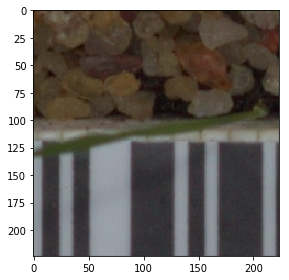

C:\Users\s110024\Documents\CV\HW1\data\train\Black-grass\0050f38b3.png
Black-grass


In [6]:
print(train['data'][0].shape)
io.imshow(train['data'][0])
io.show()
print(train['path'][0])
print(train['species'][0])

## Test Data

In [7]:
test = []
filelist = [file for file in os.listdir(TEST_FOLDER) if file.endswith('.png')]
print('Test -> {}'.format(len(filelist)))
for file in filelist:
    test.append([os.path.join(TEST_FOLDER, file), file, "", []])
test = pd.DataFrame(test, columns=['path', 'file', 'species', 'data'])
print(test.shape)
test.head(2)

Test -> 794
(794, 4)


,path,file,species,data
0,C:\Users\s110024\Documents\CV\HW1\data\test\00...,0021e90e4.png,,[]
1,C:\Users\s110024\Documents\CV\HW1\data\test\00...,003d61042.png,,[]


In [8]:
for i, file in tqdm(enumerate(test['path'])): # 794 in train
    img = io.imread(file)
    img = transform.resize(img, [DATA_SIZE, DATA_SIZE, 3])
    test['data'][i] = img

c:\programdata\miniconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(224, 224, 3)


c:\programdata\miniconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
c:\programdata\miniconda3\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


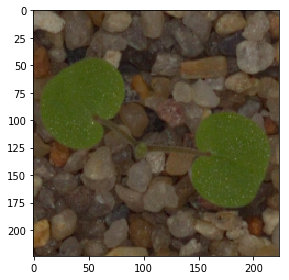

0021e90e4.png


In [9]:
print(test['data'][0].shape)
io.imshow(test['data'][0])
io.show()
print(test['file'][0])

## Using sum of absolute distance

In [10]:
for testID in tqdm(range(len(test))):
    minSAD, answerID = -1, -1
    for trainID in range(len(train)):
        distance = test['data'][testID] - train['data'][trainID]
        SAD = np.sum(np.abs(distance))
        if SAD < minSAD or minSAD == -1:
            minSAD = SAD
            answerID = trainID
    test['species'][testID] = train['species'][answerID]

In [11]:
test[['file', 'species']].to_csv('submission_SAD.csv', index=False)

## Using sum of square distance

In [12]:
for testID in tqdm(range(len(test))):
    minSSD, answerID = -1, -1
    for trainID in range(len(train)):
        distance = test['data'][testID] - train['data'][trainID]
        SSD = np.sum(distance**2)
        if SSD < minSSD or minSSD == -1:
            minSSD = SSD
            answerID = trainID
    test['species'][testID] = train['species'][answerID]

In [13]:
test[['file', 'species']].to_csv('submission_SSD.csv', index=False)

## Using HOG

In [14]:
train['grayscale'] = ""
train['hog_image'] = ""
for i in tqdm(range(len(train))):
    train['grayscale'][i] = rgb2gray(train['data'][i])
    normalised_blocks, train['hog_image'][i] = hog(train['grayscale'][i], orientations=9, pixels_per_cell=(8, 8), cells_per_block=(8, 8), visualise=True)

c:\programdata\miniconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


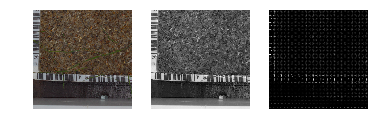

In [32]:
plt.subplot(1,3,1)
plt.imshow(train['data'][10])
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(train['grayscale'][10], cmap=plt.cm.gray)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(train['hog_image'][10], cmap=plt.cm.gray)
plt.axis('off')
plt.show()

In [16]:
test['grayscale'] = ""
test['hog_image'] = ""
for i in tqdm(range(len(test))):
    test['grayscale'][i] = rgb2gray(test['data'][i])
    normalised_blocks, test['hog_image'][i] = hog(test['grayscale'][i], orientations=9, pixels_per_cell=(8, 8), cells_per_block=(8, 8), visualise=True)

c:\programdata\miniconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


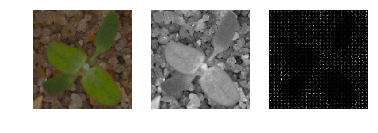

In [33]:
plt.subplot(1,3,1)
plt.imshow(test['data'][10])
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(test['grayscale'][10], cmap=plt.cm.gray)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(test['hog_image'][10], cmap=plt.cm.gray)
plt.axis('off')
plt.show()

In [18]:
for testID in tqdm(range(len(test))):
    minSSD, answerID = -1, -1
    for trainID in range(len(train)):
        distance = test['hog_image'][testID] - train['hog_image'][trainID]
        SSD = np.sum(distance**2)
        if SSD < minSSD or minSSD == -1:
            minSSD = SSD
            answerID = trainID
    test['species'][testID] = train['species'][answerID]

In [19]:
test[['file', 'species']].to_csv('submission_HOG.csv', index=False)

## Using Local Binary Pattern

In [53]:
train['lbp_image'] = ""
for i in tqdm(range(len(train))):
    train['lbp_image'][i] = local_binary_pattern(train['grayscale'][i], P=8, R=1)

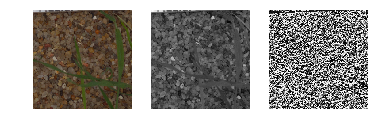

In [54]:
plt.subplot(1,3,1)
plt.imshow(train['data'][20])
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(train['grayscale'][20], cmap=plt.cm.gray)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(train['lbp_image'][20], cmap=plt.cm.gray)
plt.axis('off')
plt.show()

In [55]:
test['lbp_image'] = ""
for i in tqdm(range(len(test))):
    test['lbp_image'][i] = local_binary_pattern(test['grayscale'][i], P=8, R=1)

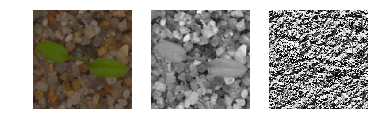

In [56]:
plt.subplot(1,3,1)
plt.imshow(test['data'][20])
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(test['grayscale'][20], cmap=plt.cm.gray)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(test['lbp_image'][20], cmap=plt.cm.gray)
plt.axis('off')
plt.show()

In [57]:
print(test['lbp_image'][20])

[[  0.  16.  16. ... 112. 112. 112.]
 [198. 255. 172. ...  48. 248. 112.]
 [193.  64. 253. ... 252. 249.  96.]
 ...
 [  7.  15.  15. ... 224. 112. 124.]
 [199. 239. 239. ...   0.  16. 120.]
 [  1.   1.   1. ...  31.  12.  24.]]


In [58]:
for testID in tqdm(range(len(test))):
    minSSD, answerID = -1, -1
    for trainID in range(len(train)):
        distance = test['lbp_image'][testID] - train['lbp_image'][trainID]
        SSD = np.sum(distance**2)
        if SSD < minSSD or minSSD == -1:
            minSSD = SSD
            answerID = trainID
    test['species'][testID] = train['species'][answerID]

In [61]:
test[['file', 'species']].to_csv('submission_LBP.csv', index=False)

In [66]:
print(train['grayscale'][0])

[[0.18859157 0.17641714 0.20755524 ... 0.32013024 0.33108091 0.27857399]
 [0.18706746 0.19755135 0.23108622 ... 0.33284014 0.32398943 0.27986294]
 [0.18435145 0.2084261  0.23702652 ... 0.32132369 0.31042875 0.28634435]
 ...
 [0.53958001 0.58906767 0.58375089 ... 0.32870571 0.2393097  0.1989866 ]
 [0.54381903 0.58381425 0.58090297 ... 0.32119727 0.25729256 0.21519338]
 [0.50943716 0.54915852 0.54489524 ... 0.30708504 0.23845568 0.19054205]]


## Using Co-occurrence Matrix

In [119]:
train['comatrix'] = ""
for i in tqdm(range(len(train))):
    img = img_as_ubyte(train['grayscale'][i])
    train['comatrix'][i] = greycomatrix(img, distances=[1], angles=[0])

c:\programdata\miniconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
c:\programdata\miniconda3\lib\site-packages\skimage\feature\texture.py:109: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(image.dtype, np.float):


c:\programdata\miniconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
c:\programdata\miniconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "
c:\programdata\miniconda3\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


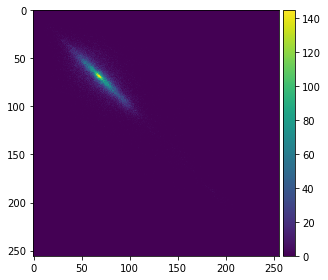

In [142]:
io.imshow(train['comatrix'][20][:,:,0,0])

In [143]:
test['comatrix'] = ""
for i in tqdm(range(len(test))):
    img = img_as_ubyte(test['grayscale'][i])
    test['comatrix'][i] = greycomatrix(img, distances=[1], angles=[0])

c:\programdata\miniconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
c:\programdata\miniconda3\lib\site-packages\skimage\feature\texture.py:109: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(image.dtype, np.float):


c:\programdata\miniconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
c:\programdata\miniconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "
c:\programdata\miniconda3\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


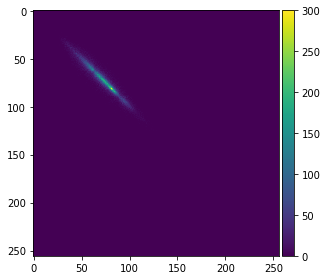

In [144]:
io.imshow(test['comatrix'][20][:,:,0,0])

In [145]:
for testID in tqdm(range(len(test))):
    minSSD, answerID = -1, -1
    for trainID in range(len(train)):
        distance = test['comatrix'][testID] - train['comatrix'][trainID]
        SSD = np.sum(distance**2)
        if SSD < minSSD or minSSD == -1:
            minSSD = SSD
            answerID = trainID
    test['species'][testID] = train['species'][answerID]

In [146]:
test[['file', 'species']].to_csv('submission_comatrix.csv', index=False)